# Imports, Definitions, and Instantiating the overlay

In [1]:
from mkidgen3.daccomb import generate as gen_comb
from mkidgen3.testutils import *
import mkidgen3.testutils as tu
from mkidgen3.fixedpoint import *
from mkidgen3.pynq import dma_status  ## also activates the drivers
import logging
import numpy as np
import time
import pynq
from pynq import PL, Overlay, DefaultIP, allocate, DefaultHierarchy
from fpbinary import FpBinary, OverflowEnum, RoundingEnum
import itertools
import matplotlib.pyplot as plt
import scipy.signal
from logging import getLogger
import os
from glob import glob

FP16_23 = lambda x: FpBinary(int_bits=-7, frac_bits=23, signed=True, value=x)
FP16_14 = lambda x: FpBinary(int_bits=2, frac_bits=14, signed=True, value=x)
FP16_13 = lambda x: FpBinary(int_bits=3, frac_bits=13, signed=True, value=x)
FP16_8 = lambda x: FpBinary(int_bits=8, frac_bits=8, signed=True, value=x)
FP16_8bf = lambda x: FpBinary(int_bits=8, frac_bits=8, signed=True, bit_field=x)

n_res = 2048
n_bin = 4096
matched_filter_loaded=False
logging.basicConfig()
logging.getLogger('').setLevel('DEBUG')
logging.getLogger('__main__').setLevel('INFO')

Load the overlay and extract the dma core

In [2]:
def pack16_to_32(data):
    it=iter(data)
    vals=[x|(y<<16) for x, y in zip(it,it)]
    if data.size%2:
        vals.append(data[-1])
    return np.array(vals, dtype=np.uint32)
    
class PhasematchDriver(DefaultHierarchy):
    N_TEMPLATE_TAPS = 30
    N_RES = 2048
    N_RES_P_LANE = 512
    N_LANES = 4
    MAX_COEFF_VALUE = 127  # 16 bits, 1 sign, 8 fractional

    def __init__(self, description):
        super().__init__(description)
        self.fifo = self.axi_fifo_mm_s_0

    @staticmethod
    def checkhierarchy(description):
        for k in ('axi_fifo_mm_s_0',):
            if k not in description['ip']:
                return False
        return True

    @staticmethod
    def vet_coeffs(coeffs):
        if coeffs.size != PhasematchDriver.N_TEMPLATE_TAPS:
            raise ValueError('Incorrect number of taps')
        if max(abs(coeffs)) > PhasematchDriver.MAX_COEFF_VALUE:
            raise ValueError(f'Coefficients must be <= {PhasematchDriver.MAX_COEFF_VALUE}')

    @staticmethod
    def vet_res_id(res_id):
        if 0 > res_id or res_id >= PhasematchDriver.N_RES:
            raise ValueError(f'resID must be in [0-{PhasematchDriver.N_RES}]')

    @staticmethod
    def reorder_coeffs(coeffs):
        """convert taps to order needed by a reload packet"""
        PhasematchDriver.vet_coeffs(coeffs)
        return coeffs[::-1]  # see coefficient reload tab for order in block design

    def load_coeff(self, res_id, coeffs, raw=False):
        """
        A reload packet consists of the coefficients and the coefficient set number
        
        The coeffs must be ordered such that tap0 (most recent) is last. 

        See block diagram for layout. Resonators assigned to lanes 0-3 in consecutive sets of 512.

        FIRs have one reload slot and are in "on vector" update mode. Data must be driven through core between calls that 
        use the same FIR core to trigger a config event in the core. 

        If raw the coeffs are cast directly to uint16 by numpy and sent as is.

        See pg149 pg 18
        """
        self.vet_res_id(res_id)
        lane = res_id // PhasematchDriver.N_RES_P_LANE
        reload_packet = np.zeros(coeffs.size + 1, dtype=np.uint16)
        reload_packet[0] = res_id % PhasematchDriver.N_RES_P_LANE
        if raw:
            reload_packet[1:] = coeffs
        else:
            fpgen = lambda x: FpBinary(int_bits=0, frac_bits=16, signed=True, value=x)
            reload_packet[1:] = [fpgen(c).__index__() for c in PhasematchDriver.reorder_coeffs(coeffs)]

        cfg_packet=np.arange(PhasematchDriver.N_RES_P_LANE, dtype=np.uint16)

        reload_packet=pack16_to_32(reload_packet)
        cfg_packet=pack16_to_32(cfg_packet)
        
        self.fifo.tx(reload_packet, destination=lane, last_bytes=2)  #reload channels are 0,2,4,6
        #self.fifo.tx(cfg_packet, destination=2*lane+1)  #Send a config packet to trigger the reload
            
    def load_coeff_sets(self, coeff_sets):
        for res in range(PhasematchDriver.N_RES):
            self.load_coeff(res, coeff_sets[res])

class AxisFIFO(DefaultIP):
    bindto = ['xilinx.com:ip:axi_fifo_mm_s:4.2']

    def __init__(self, description):
        super().__init__(description=description)
        self.length = 512

    def reset_tx_fifo(self):
        self.register_map.TDFR = 0x000000A5
        while not self.register_map.ISR.TRC:
            getLogger(__name__).debug('Waiting on tx reset complete...')
            time.sleep(1)
        
    def tx(self, data, destination=0, last_bytes=4):
        """Data must be an array of uint32"""
        if data.size > self.tx_vacancy:
            raise ValueError('Insufficient room in fifo for data')
            
        getLogger(__name__).debug(f'ISR at TX start: {repr(self.register_map.ISR)}')
        self.register_map.ISR = 0xFFFFFFFF  # Write to clear reset done interrupt bits
        self.register_map.IER.TPOE = 1  # Interrupt if we try to load too much data (should not be possible)
        self.register_map.IER.TSE = 1  # Interrupt on transmit size errors
        self.register_map.IER.TC = 1  # Enable transmit complete interrupt
        self.register_map.TDR.TDEST = destination  # Transmit Destination address
        
        for x in data:
            self.mmio.write(self.register_map.TDFD.address, int(x))  # Write value

        self.register_map.TLR.TXL = (data.size-1) * 4 + last_bytes # Transmit length in bytes, this starts transmission
        self.interrupt.wait()  # wait for the transmit to complete

        getLogger(__name__).debug(f'ISR at TX end: {repr(self.register_map.ISR)}')

    def rx(self):
        if not self.register_map.ISR & 0x04000000:  # TODO what is the mask indicating data is avaialble so pg080 pg21
            return None
        self.register_map.ISR = 0xFFFFFFFF  # Write to clear reset done interrupt bits
        getLogger(__name__).debug(f'ISR at RX start: {repr(self.register_map.ISR)}')
        occ = self.rx_occupancy
        length = self.register_map.RLR
        dest = self.register_map.RDR
        data = []
        for i in range(length // 4):
            data.append(self.register_map.RDR)
        occ = self.rx_occupancy
        return data, dest

    def powerup(self):
        assert self.register_map.ISR == 0x01D00000  # Read interrupt status register (indicates transmit reset complete
        # and receive reset complete)
        self.register_map.ISR = 0xFFFFFFFF  # Write to clear reset done interrupt bits

    @property
    def tx_vacancy(self):
        return self.register_map.TDFV.Vacancy

    @property
    def rx_occupancy(self):
        return self.register_map.RDFO.Occupancy
    
    
class PhaseFIRCoeffFile:
    def __init__(self, file):
        self.file=file
        npz = np.load(self.file)
        self.coeffs = npz['filters']

## A function to send the data
For every 256 bit transaction (8xIQ) we decimate by 2 and reshape to 128b and broadcast to 4 paths of IQ 32b, which goes to a 16b phase and is filtered and concatenated. So for every transaction (32 bytes) in we get one 64b/8B transaction out with phases for 4 resonators. TLAST is still every 2048 resonators. So 2 input packets should get the 2048 16 bit phases for the resonators.

The comb needs to be padded with 2047 0s between every sample (or broadcast)
packets_in = np.zeros(comb.size*2048, dtype=comb.dtype)
packets_in[::8] = comb
packets_in = packets_in.reshape(packets_in.size//2048, 2048)

but this would be 10GB of data. So instead we just will send a custom packet each time. Where packet_in[i,:4]==comb[i]

In [3]:
def drive_data(dma, data, zeros=False, packet_size=2048, in_per_out=2, n_out=1, iqin=True, phaseout=True, 
               n_latency_packets=0, recieve=True, fpgen=FP16_15, fprecv=(3, 13)):
    
    global _n_latency_packets
    try:
        _n_latency_packets+1
    except NameError:
        _n_latency_packets=n_latency_packets
        
    nsamples=(in_per_out*n_out+_n_latency_packets)
    
    buf_shape=(nsamples*packet_size*(2 if iqin else 1),)
    buffer = allocate(shape=buf_shape, dtype=np.uint16)
    
    if not zeros:
        data=data[:nsamples]
        ibits = [fpgen(x).__index__() for x in data.real]
        qbits = [fpgen(x).__index__() for x in data.imag]
        data = np.zeros(2 * data.size, dtype=np.uint16)
        data[::2] = ibits
        data[1::2] = qbits
        buffer[::2][::packet_size]=data[::2]
        buffer[1::2][::packet_size]=data[1::2]
        
    dma.sendchannel.transfer(buffer)
    dma.sendchannel.wait()
    buffer.close()
    _n_latency_packets=0
    
    if recieve:
        out = np.zeros(packet_size*(1 if phaseout else 2)*n_out, dtype=np.uint16)
        total_packet_size = packet_size*(1 if phaseout else 2)
        if fprecv is None:
            fp = lambda x: x
        else:
            fp = lambda x: float(FpBinary(int_bits=fprecv[0], frac_bits=fprecv[1], signed=True, bit_field=int(x)))
        buffer = allocate(shape=(total_packet_size,), dtype=np.uint16)
        for i in range(n_out):
            dma.recvchannel.transfer(buffer)
            dma.recvchannel.wait()
            out[i*total_packet_size:(i+1)*total_packet_size]=buffer
        buffer.close()
        
        return np.array([fp(x) for x in out])

Load the overlay into the FPGA

In [4]:
ol = Overlay('/home/xilinx/overlayfiles/test_phasematch/test_phasematch.bit',ignore_version=True)
ol.download()
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/overlayfiles/test_phasematch/test_phasematch.bit
PL Timestamp: 2020/8/24 23:20:21 +429294
Overlay timestamp: 2020/8/24 23:20:21 +429294  Loaded: True


In [5]:
pm=ol.phasematch
fifo=ol.phasematch.fifo
dma = ol.axi_dma_0
ddc=ol.reschan.resonator_dds_0

DEBUG:asyncio:Using selector: EpollSelector


## Prepare the Data

In [6]:
n_total_packets=301  # How many packets
sample_rate=2.048e6
PULSE_DECAY_TIME=15e-6
pulse_times=np.linspace(PULSE_DECAY_TIME,4*5*PULSE_DECAY_TIME, 5)
amplitude = 1

Turn one ideal pulse into phase. Take 30 points, time reverse it, and normalize it so that the maximum of a filtered pulse gives the original pulse height.

In [7]:
def pulse(t, decay):
    heavy_e=-np.e**(-t/PULSE_DECAY_TIME)*np.heaviside(t,1)/2
    return heavy_e/2 + heavy_e*1j

def gen_matched_filt(n_taps=30, n_before=2, plot=True, sample_rate=1.024e6):
    t=np.arange(n_taps)/sample_rate
    x=pulse(t-n_before*np.diff(t)[0], PULSE_DECAY_TIME)+1
    phase=np.arctan2(x.imag, x.real)/np.pi
    
    matched = phase[::-1]
    norm=np.sign(phase[np.abs(phase).argmax()])*np.abs(phase).max()/np.abs(scipy.signal.convolve(phase, matched,'same')).max()
    if plot:
        plt.subplot(1,2,1)
        plt.plot(x.real)
        plt.plot(x.imag)
        plt.xlabel('Sample')
        plt.ylabel('I and Q')
        plt.subplot(1,2,2)
        plt.plot(phase, label='phase')
        plt.plot(matched, label='filt')
        plt.plot(scipy.signal.convolve(phase, matched*norm,'same'),label='convol')
        plt.xlabel('Sample')
        plt.ylabel('Phase')
        plt.legend()
        plt.tight_layout()
    return matched*norm

Generate the complex waveform for a single resonator.

Comb shape: (807,). 
Total Samples: 807. Memory: 0 MB
Max value: 1.0.
Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)
Resulting samples per output bin: 0.39404296875


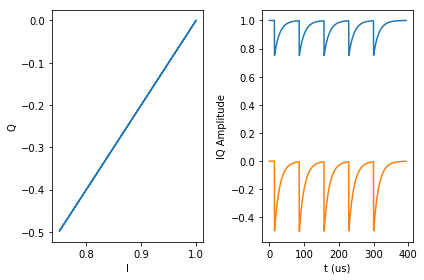

In [8]:
%matplotlib inline
max_t=1.25*(PULSE_DECAY_TIME+pulse_times.max())  #How many waveform samples do we need to generate
n_samples=int(np.ceil(max_t*sample_rate))
t = np.arange(n_samples)/sample_rate

comb=np.ones_like(t, dtype=np.complex64)
for t0 in pulse_times:
    comb+=pulse(t-t0, PULSE_DECAY_TIME)
comb*=amplitude

print(f"Comb shape: {comb.shape}. \nTotal Samples: {comb.size}. Memory: {comb.size*8/1024**2:.0f} MB\n"
      f"Max value: {np.abs(comb).max()}.\n"
      f"Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)\n"
      f"Resulting samples per output bin: {comb.size*2/n_bin}")

plt.tight_layout()
plt.figure()
plt.subplot(1,2,1)
plt.plot(comb.real,comb.imag)
plt.xlabel('I')
plt.ylabel('Q')
plt.subplot(1,2,2)
plt.plot(t*1e6, comb.real)
plt.plot(t*1e6, comb.imag)
plt.ylabel('IQ Amplitude')
plt.xlabel('t (us)')
plt.tight_layout()

### Configure the phase FIRs

Make the matched filter

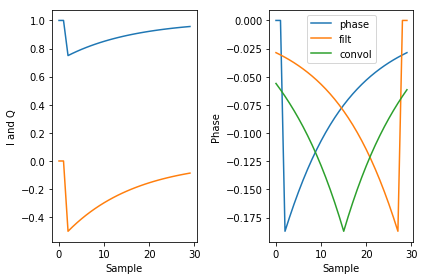

In [9]:
%matplotlib inline
matched_filt=gen_matched_filt(n_taps=30,n_before=2, plot=True)

Load the coeffs

In [10]:
for i in range(512):
    getLogger(__name__).info(f'Loading coefficient set {i}')
    for j in range(4):  # We can load one set in each FIR bank before needing to trigger a config event.
        res_id = j*512 + i
        data = matched_filt
#         data=np.zeros_like(matched_filt, dtype=np.uint16)
#         data[-1]=0x7fff
        ol.phasematch.load_coeff(res_id, data)
    # Send zeros to trigger a config event, the config block will ensure a config packet is ready
    drive_data(dma,0, zeros=True, in_per_out=2, n_out=1, phaseout=True, n_latency_packets=1)
matched_filter_loaded=True

INFO:__main__:Loading coefficient set 0
INFO:__main__:Loading coefficient set 1
INFO:__main__:Loading coefficient set 2
INFO:__main__:Loading coefficient set 3
INFO:__main__:Loading coefficient set 4
INFO:__main__:Loading coefficient set 5
INFO:__main__:Loading coefficient set 6
INFO:__main__:Loading coefficient set 7
INFO:__main__:Loading coefficient set 8
INFO:__main__:Loading coefficient set 9
INFO:__main__:Loading coefficient set 10
INFO:__main__:Loading coefficient set 11
INFO:__main__:Loading coefficient set 12
INFO:__main__:Loading coefficient set 13
INFO:__main__:Loading coefficient set 14
INFO:__main__:Loading coefficient set 15
INFO:__main__:Loading coefficient set 16
INFO:__main__:Loading coefficient set 17
INFO:__main__:Loading coefficient set 18
INFO:__main__:Loading coefficient set 19
INFO:__main__:Loading coefficient set 20
INFO:__main__:Loading coefficient set 21
INFO:__main__:Loading coefficient set 22
INFO:__main__:Loading coefficient set 23
INFO:__main__:Loading coef

INFO:__main__:Loading coefficient set 198
INFO:__main__:Loading coefficient set 199
INFO:__main__:Loading coefficient set 200
INFO:__main__:Loading coefficient set 201
INFO:__main__:Loading coefficient set 202
INFO:__main__:Loading coefficient set 203
INFO:__main__:Loading coefficient set 204
INFO:__main__:Loading coefficient set 205
INFO:__main__:Loading coefficient set 206
INFO:__main__:Loading coefficient set 207
INFO:__main__:Loading coefficient set 208
INFO:__main__:Loading coefficient set 209
INFO:__main__:Loading coefficient set 210
INFO:__main__:Loading coefficient set 211
INFO:__main__:Loading coefficient set 212
INFO:__main__:Loading coefficient set 213
INFO:__main__:Loading coefficient set 214
INFO:__main__:Loading coefficient set 215
INFO:__main__:Loading coefficient set 216
INFO:__main__:Loading coefficient set 217
INFO:__main__:Loading coefficient set 218
INFO:__main__:Loading coefficient set 219
INFO:__main__:Loading coefficient set 220
INFO:__main__:Loading coefficient 

INFO:__main__:Loading coefficient set 394
INFO:__main__:Loading coefficient set 395
INFO:__main__:Loading coefficient set 396
INFO:__main__:Loading coefficient set 397
INFO:__main__:Loading coefficient set 398
INFO:__main__:Loading coefficient set 399
INFO:__main__:Loading coefficient set 400
INFO:__main__:Loading coefficient set 401
INFO:__main__:Loading coefficient set 402
INFO:__main__:Loading coefficient set 403
INFO:__main__:Loading coefficient set 404
INFO:__main__:Loading coefficient set 405
INFO:__main__:Loading coefficient set 406
INFO:__main__:Loading coefficient set 407
INFO:__main__:Loading coefficient set 408
INFO:__main__:Loading coefficient set 409
INFO:__main__:Loading coefficient set 410
INFO:__main__:Loading coefficient set 411
INFO:__main__:Loading coefficient set 412
INFO:__main__:Loading coefficient set 413
INFO:__main__:Loading coefficient set 414
INFO:__main__:Loading coefficient set 415
INFO:__main__:Loading coefficient set 416
INFO:__main__:Loading coefficient 

### Configure the DDS

We are going to feed in tones at baseband, so the increment and phase offset are 0.

In [ ]:
tones=np.zeros((2,2048))
ddc.tones=tones

## Manually test a single path

res_id=3
coeffs=np.arange(30)
lane = res_id // PhasematchDriver.N_RES_P_LANE
reload_packet = np.zeros(coeffs.size + 1, dtype=np.uint16)
reload_packet[0] = res_id % PhasematchDriver.N_RES_P_LANE
FP32_8 = lambda x: FpBinary(int_bits=32 - 9, frac_bits=8, signed=True, value=x)
reload_packet[1:] = [FP32_8(c).__index__() for c in PhasematchDriver.reorder_coeffs(coeffs)]

cfg_packet=np.arange(PhasematchDriver.N_RES_P_LANE, dtype=np.uint16)

reload_packet=pack16_to_32(reload_packet)
cfg_packet=pack16_to_32(cfg_packet)

fifo.tx(reload_packet, destination=0, last_bytes=2)  #reload channels are 0-3
pm.fifo.register_map
fifo.tx(reload_packet, destination=1, last_bytes=2)
pm.fifo.register_map

ol.phasematch.load_coeff(res_id, np.arange(30))

fifo.register_map.SRR=0x000000A5
fifo.reset_tx_fifo()

# Generate and feed a stream

First create a timeseries of IQ values for a DDSed resonator.

In [11]:
n_out=4
out=[]
n_latency_packets=1
n_sent=0
while n_sent+2*n_out<comb.size:
    # Send zeros to trigger a config event, the config block will ensure a config packet is ready  
    out.append(drive_data(dma, comb[n_sent:], in_per_out=2, n_out=n_out, phaseout=True, fpgen=FP16_15, 
                          fprecv=None, n_latency_packets=n_latency_packets)[::2048])
    n_sent+=n_latency_packets*(n_sent==0)+2*n_out    
out=np.concatenate(out)

In [12]:
outfp=np.array([float(FpBinary(8,8,True,bit_field=int(x))) for x in out])
#outfp2=np.array([float(FpBinary(9,7,True,bit_field=int(x))) for x in out]) #Use this line if the plots at the end aren't matching

## Simulate the results

First define a bunch of helpers

In [15]:
with open(f"data/fclowpass.coe",'r') as f:
    lines=f.readlines()[1:]
lines[0]=lines[0].partition('=')[-1]
lpcoeffs=np.array(list(map(float,''.join(lines).replace(';','').replace('\n','').split(','))))  #c19-0

In [16]:
#Lowpass
lowpassed = np.zeros(comb.size-lpcoeffs.size+1, dtype=np.complex64)
lowpassed.real = np.convolve(comb.real, lpcoeffs[::-1], mode='valid')
lowpassed.imag = np.convolve(comb.imag, lpcoeffs[::-1], mode='valid')
lowpassed=scipy.signal.decimate(lowpassed,2, n=lpcoeffs.size-1, ftype='fir', zero_phase=False)

#arctan the IQ
phased = np.arctan2(lowpassed.imag, lowpassed.real)/np.pi

#Filter the phases
matched = np.convolve(phased, matched_filt, mode='valid')

Text(0.5,0,'t (us)')

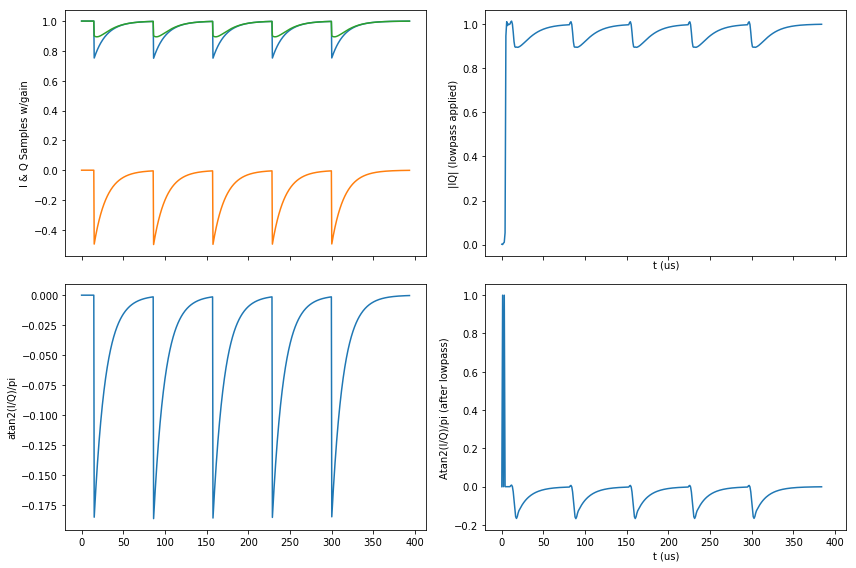

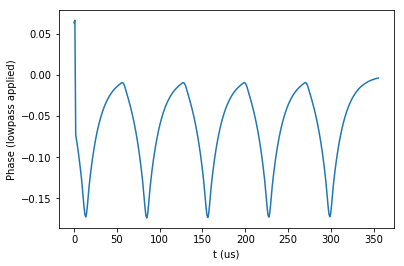

In [17]:
%matplotlib inline
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True)
plt.sca(ax.flat[0])
plt.plot(t*1e6, comb.real)
plt.plot(t*1e6, comb.imag)
plt.plot(t*1e6, np.abs(comb))
plt.ylabel('I & Q Samples w/gain')

plt.sca(ax.flat[1])
plt.plot(t[:lowpassed.size*2:2]*1e6,np.abs(lowpassed))
plt.ylabel('|IQ| (lowpass applied)')
plt.xlabel('t (us)')

plt.sca(ax.flat[2])
plt.plot(t*1e6,np.arctan2(comb.imag,comb.real)/np.pi)
plt.ylabel('atan2(I/Q)/pi')


plt.sca(ax.flat[3])
plt.plot(t[:phased.size*2:2]*1e6,phased)
plt.ylabel('Atan2(I/Q)/pi (after lowpass)')
#plt.xlim(0,1500)
plt.xlabel('t (us)')
plt.tight_layout()

plt.figure()
plt.plot(t[:matched.size*2:2]*1e6,matched, label='Python')
plt.ylabel('Phase (lowpass applied)')
plt.xlabel('t (us)')
#plt.xlim(0,1400)

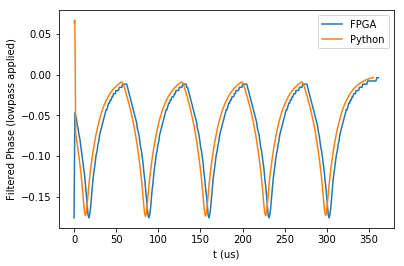

In [18]:
clip_ndx=29
clipped_fpga=outfp[clip_ndx:]
fpga_t=t[::2][:clipped_fpga.size]
plt.plot(1e6*fpga_t,clipped_fpga, label='FPGA')

if matched_filter_loaded:
    plt.plot(t[:matched.size*2:2]*1e6,matched, label='Python')
    plt.ylabel('Filtered Phase (lowpass applied)')
else:
    plt.plot(t[:phased.size*2:2]*1e6,-phased, label='Python')
    plt.ylabel('Phase (lowpass applied)')

plt.xlabel('t (us)')
plt.legend()